# *(Sherman & Rinzel, 1992)* Gap junction leads to anti-synchronization

Implementation of the paper: 

- *Sherman, A., & Rinzel, J. (1992). Rhythmogenic effects of weak electrotonic coupling in neuronal models. Proceedings of the National Academy of Sciences, 89(6), 2471-2474.*

Author: 

- Chaoming Wang (chao.brain@qq.com)

In [1]:
%matplotlib inline

import brainpy as bp
bp.math.set_dt(0.05)

In [2]:
import numba as nb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Fig 1: weakly coupled cells can oscillate antiphase

The "square-wave burster" model is given by:

$$
\begin{split}
\tau {dV \over dt} &= -I_{in}(V) - I_{out}(V) - g_s S (V-V_K) + I + I_j \\
\tau {dn \over dt} &= \lambda (n_{\infty} - n)
\end{split}
$$

where 

$$
\begin{split}
I_{in}(V) &= g_{Ca} m (V-V_{Ca}) \\
I_{out}(V) &= g_Kn(V-V_K) \\
m &= m_{\infty}(V) \\
x_{\infty} (V) &= {1 \over 1 + \exp[(V_x - V) / \theta_x]} \\
I_j &= -g_c (V-\bar{V})
\end{split}
$$

where 

$$
\begin{split}
S &= 0.15 \\
\lambda &= 0.8 \\
V_m &= -20 \\
\theta_m &= 12 \\
V_n &= -17 \\
\theta_n &= 5.6 \\
V_{Ca} &= 25 \\
V_{K} &= -75 \\
\tau &= 20 \, \mathrm{ms} \\
g_{Ca} &= 3.6 \\
g_K &= 10 \\
g_s &= 4
\end{split}
$$

At t = 0.5 s the junctional-coupling conductance, $g_c$, is raised to 0.08, and a small symmetry-breaking perturbation (0.3 mV) is applied to one of the
cells. This destabilizes the single-cell oscillation and leads to an
antiphase oscillation. At t = 5.5 s the single-cell behavior is restored
by increasing $g_c$ to 0.24; alternatively, one could set $g_c$ to 0, but then
the two cells would not be in-phase.

In [3]:
lambda_ = 0.8
V_m = -20
theta_m = 12
V_n = -17
theta_n = 5.6
V_ca = 25
V_K = -75
tau = 20
g_ca = 3.6
g_K = 10
g_s = 4

In [4]:
@nb.njit
def revert(V):
    return bp.math.concatenate((V[1:], V[:1]))

In [5]:
@bp.odeint(method='exponential_euler')
def int_V_n(V, n, t, gc, I, S):
    I_in = g_ca / (1 + bp.math.exp((V_m - V) / theta_m)) * (V - V_ca)
    I_out = g_K * n * (V - V_K)
    Is = g_s * S * (V - V_K)
    Ij = gc * (V - revert(V))
    dV = (- I_in - I_out - Is - Ij + I) / tau
    
    n_inf = 1 / (1 + bp.math.exp((V_n - V) / theta_n))
    dn = lambda_ * (n_inf - n) / tau
    
    return dV, dn

In [6]:
def plot_V_gc_I(times, hist_V, hist_gc, hist_I0, duration):
    fig, gs = bp.visualize.get_figure(5, 1, 2, 12)

    fig.add_subplot(gs[0:3, 0])
    plt.plot(times, bp.math.array(hist_V))
    plt.ylabel('V [mV]')
    plt.xlim(*duration)

    fig.add_subplot(gs[3, 0])
    plt.plot(times, bp.math.array(hist_gc))
    plt.ylabel(r'$g_c$')
    plt.xlim(*duration)

    fig.add_subplot(gs[4, 0])
    plt.plot(times, bp.math.array(hist_I0))
    plt.ylabel(r'$I_0$')
    plt.xlim(*duration)

    plt.xlabel('Time [ms]')

In [7]:
S = 0.15
times = bp.math.arange(0, 7000, bp.math.get_dt())
V = bp.math.array([-55., -55.])
n = 1 / (1 + bp.math.exp((V_n - V) / theta_n))

hist_V = []
gc, _ = bp.inputs.constant_current([(0,     500), 
                                    (0.08, 5000),
                                    (0.24, 1500)])
Is, _ = bp.inputs.constant_current([(0.,                   500), 
                                    (bp.math.array([0.3, 0.]), 6500)])
for i, t in enumerate(times):
    V, n = int_V_n(V, n, t, gc[i], Is[i], S)
    hist_V.append(V)

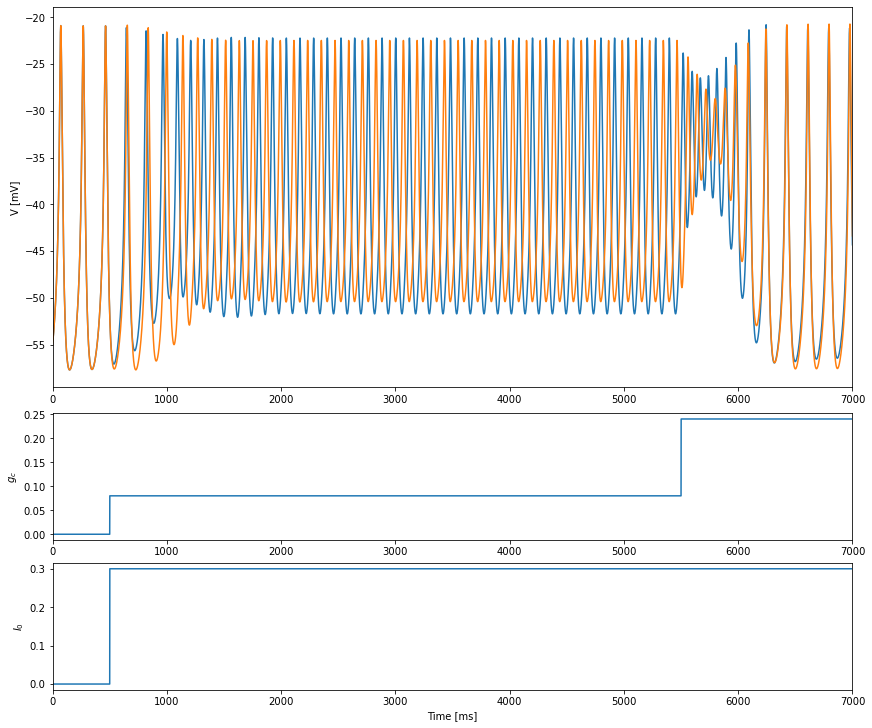

In [8]:
plot_V_gc_I(times, hist_V, gc, Is[:, 0], duration=(0, 7000))

## Fig 2: weak coupling can convert excitable cells into spikers

Cells are initially uncoupled and at rest, but one cell has a current of strength 1.0 injected for 0.5 s, resulting in two
spikes. Spiking ends when the current stimulus is removed. The
unstimulated cell remains at rest. At t = 2 s, $g_c$ is
increased to 0.04. This does not prevent the stimulated cell from
remaining at rest, but the system is now bistable and the rest state
coexists with an antiphase oscillation. A second identical current
stimulus draws both cells near enough to the oscillatory solution so
that they continue to oscillate after the stimulus terminates.

In [13]:
S = 0.177
times = bp.math.arange(0, 4500, bp.math.get_dt())
V = -62.69 * bp.math.ones(2)
n = 1 / (1 + bp.math.exp((V_n - V) / theta_n))

hist_V = []
gc = bp.inputs.section_input(values=[0, 0.04], 
                             durations=[2000, 2500])
Is = bp.inputs.section_input(values=[bp.math.array([1., 0.]), 0., bp.math.array([1., 0.]), 0.],
                             durations=[500, 2000, 500, 1500])
for i, t in enumerate(times):
    V, n = int_V_n(V, n, t, gc[i], Is[i], S)
    hist_V.append(V)

In [12]:
times.shape, Is.shape

((90000,), (100000, 2))

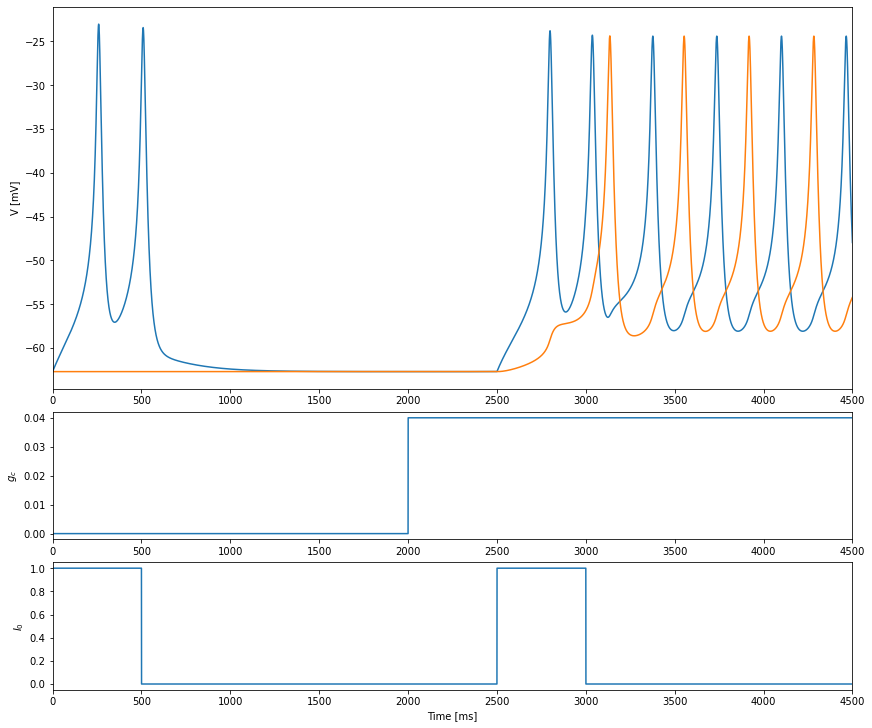

In [14]:
plot_V_gc_I(times, hist_V, gc, Is[:, 0], duration=(0, 4500))

## Fig 3: weak coupling can increase the period of bursting

We consider cells with endogenous bursting properties.
Now $S$ is a slow dynamic variable, satisfying

$$
\tau_S {dS \over dt} = S_{\infty}(V) - S
$$

with $\tau_S \gg \tau$.

In [15]:
tau_S = 35 * 1e3  # ms
V_S = -38  # mV
theta_S = 10  # mV

In [16]:
@bp.odeint(method='exponential_euler')
def int_V_n_S(V, n, S, t, lambda_, gc, I):
    I_in = g_ca / (1 + bp.math.exp((V_m - V) / theta_m)) * (V - V_ca)
    I_out = g_K * n * (V - V_K)
    Is = g_s * S * (V - V_K)
    Ij = gc * (V - revert(V))
    dV = (- I_in - I_out - Is - Ij + I) / tau
    
    n_inf = 1 / (1 + bp.math.exp((V_n - V) / theta_n))
    dn = lambda_ * (n_inf - n) / tau
    
    S_inf = 1 / (1 + bp.math.exp((V_S - V) / theta_S))
    dS = (S_inf - S) / tau_S
    
    return dV, dn, dS

In [17]:
def plot_V_S(times, hist_V, hist_S, duration):
    fig, gs = bp.visualize.get_figure(5, 1, 2, 12)

    fig.add_subplot(gs[0:3, 0])
    plt.plot(times, bp.math.array(hist_V))
    plt.ylabel('V [mV]')
    plt.xlim(*duration)

    fig.add_subplot(gs[3:, 0])
    plt.plot(times, bp.math.array(hist_S))
    plt.ylabel('S')
    plt.xlim(*duration)

    plt.xlabel('Time [ms]')

With $\lambda = 0.9$, an isolated cell alternates periodically between a
depolarized spiking phase and a hyperpolarized silent phase.

In [18]:
times = bp.math.arange(0, 50 * 1e3, bp.math.get_dt())
S = 0.172 * bp.math.ones(2)
V = V_S - theta_S * bp.math.log(1/S - 1)
n = 1 / (1 + bp.math.exp((V_n - V) / theta_n))

hist_V, hist_S = [], []
for i, t in enumerate(times):
    V, n, S = int_V_n_S(V, n, S, t, lambda_=0.9, gc=0., I=0.)
    hist_V.append(V)
    hist_S.append(S)

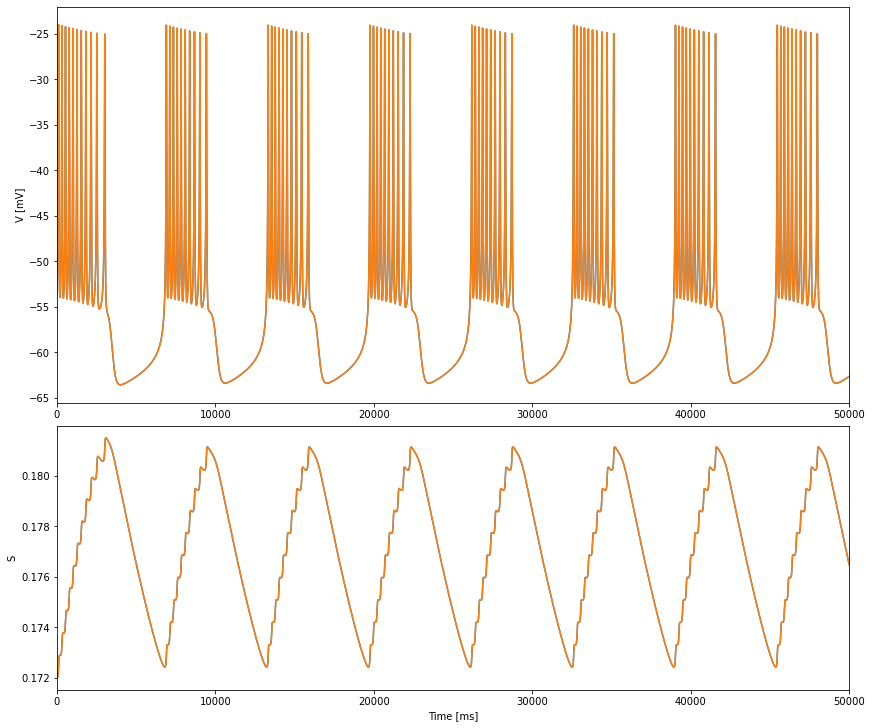

In [19]:
plot_V_S(times, hist_V, hist_S, duration=(0, 50 * 1e3))

When two identical bursters are coupled with $g_c = 0.06$ and
started in-phase, they initially follow the single-cell bursting
solution. This behavior is unstable, however, and a
new stable burst pattern emerges during the second burst
with smaller amplitude, higher frequency, antiphase spikes.

In [20]:
times = bp.math.arange(0, 50 * 1e3, bp.math.get_dt())
S = 0.172 * bp.math.ones(2)
V = V_S - theta_S * bp.math.log(1/S - 1)
n = 1 / (1 + bp.math.exp((V_n - V) / theta_n))

hist_V, hist_S = [], []
for i, t in enumerate(times):
    V, n, S = int_V_n_S(V, n, S, t, lambda_=0.9, gc=0.06, I=0.)
    hist_V.append(V)
    hist_S.append(S)

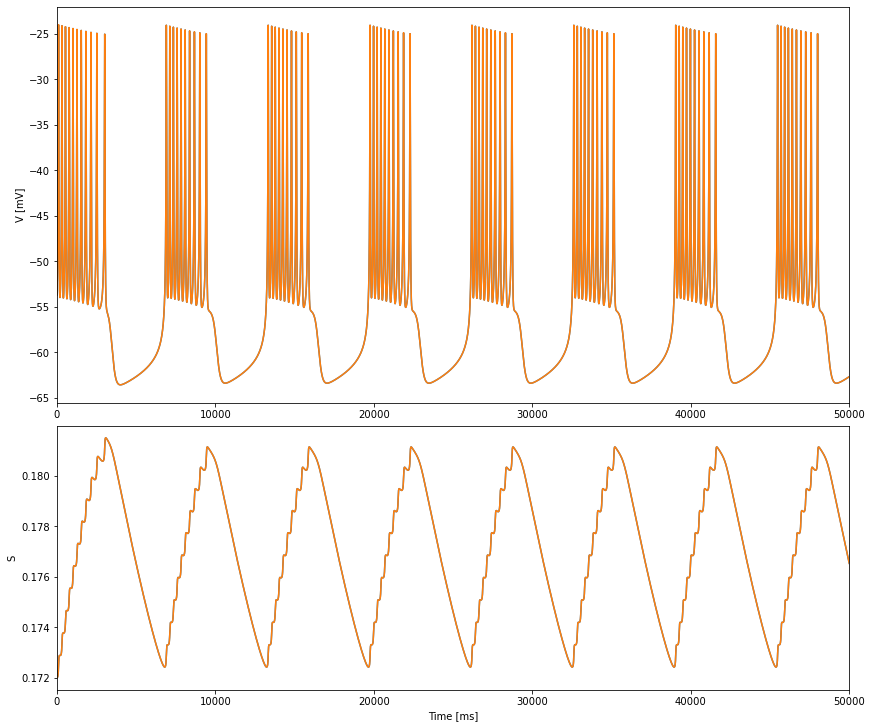

In [21]:
plot_V_S(times, hist_V, hist_S, duration=(0, 50 * 1e3))

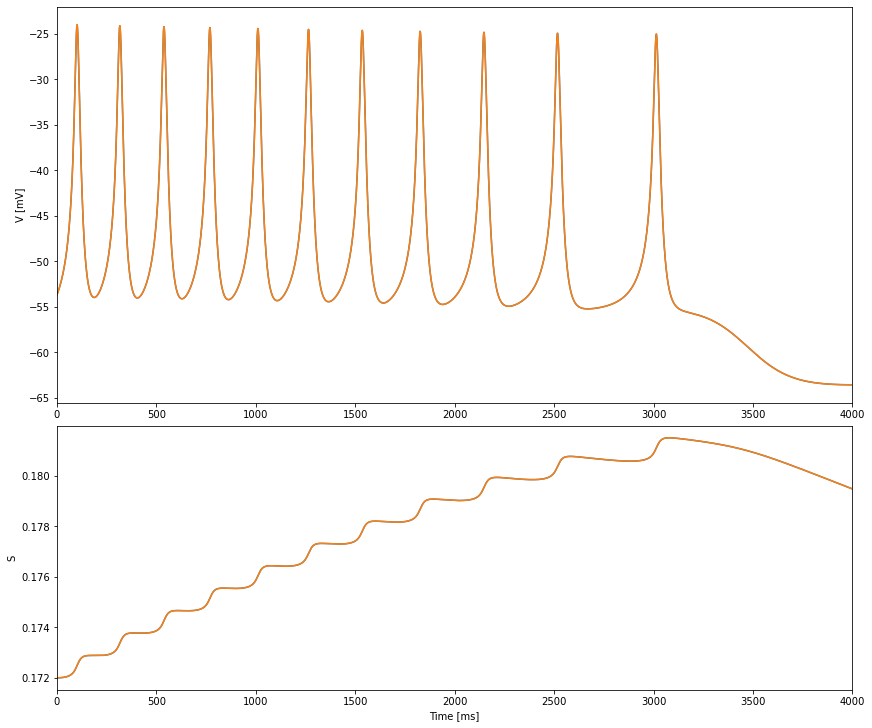

In [22]:
start,   end   = 0,                           4*1e3
start_i, end_i = int(start/bp.math.get_dt()), int(end/bp.math.get_dt())
plot_V_S(times[start_i: end_i], 
         hist_V[start_i: end_i], 
         hist_S[start_i: end_i], 
         duration=(start, end))

## Fig 4: weak coupling can convert spikers to bursters

Parameters are the same as in Fig. 3, except $\lambda = 0.8$, resulting in repetitive spiking (beating) instead of bursting. Oscillations in $S$ are nearly abolished. Two identical cells are started with identical initial conditions (only one shown for clarity). At t = 20 s, $g_c$ is increased to
0.04 (right arrow) and a small symmetry-breaking perturbation (0.3
mV) is applied to one cell. After a brief transient, the two cells begin
to burst in-phase but with antiphase spikes, as in Fig. 3.

In [23]:
times = bp.math.arange(0, 50 * 1e3, bp.math.get_dt())
S = 0.172 * bp.math.ones(2)
V = V_S - theta_S * bp.math.log(1/S - 1)
n = 1 / (1 + bp.math.exp((V_n - V) / theta_n))

gc = bp.inputs.section_input(values=[0., 0.04],
                             durations=[20 * 1e3, 30 * 1e3])
Is = bp.inputs.section_input(values=[0., bp.math.array([0.3, 0.])],
                             durations=[20 * 1e3, 30 * 1e3])
hist_V, hist_S = [], []
for i, t in enumerate(times):
    V, n, S = int_V_n_S(V, n, S, t, lambda_=0.8, gc=gc[i], I=Is[i])
    hist_V.append(V)
    hist_S.append(S)

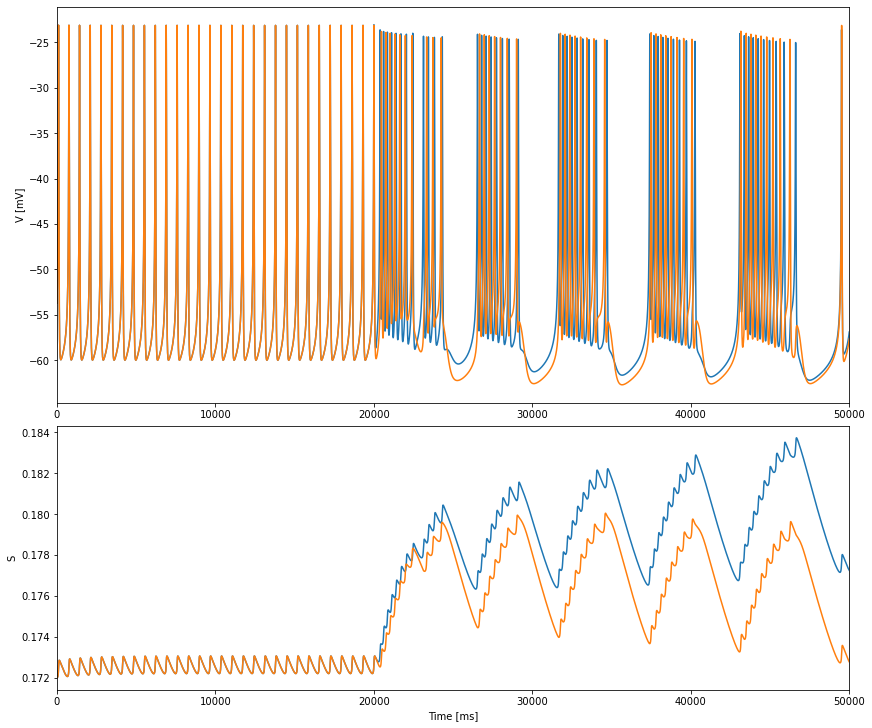

In [24]:
plot_V_S(times, hist_V, hist_S, duration=(0, 50 * 1e3))